## Training multi-fidelity neural networks for oscillatory shear test, loss modulus ($G''$)
The output of this notebook is the model's stored training, which is used to predict $G''$.

### Importing the dependencies

In [10]:
from time import time
from datetime import datetime
import os
import sys
import math
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker

### Loading the Lo-Fi and Hi-Fi data
Similar to Lo-Fi data generation, it is possible to sample the Hi-Fi data and/or exclude flow curves as needed. We have three inputs (`Strain`, `Temperature`, `AngFreq`), while the output is the loss modulus, `LossM`. The $T=40^\circ\text{C}$ loss modulus test is masked, similar to Lo-Fi data generation notebook.

In [11]:
DTYPE = 'float32'
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
df = {}
Shuffle = False

url_lf = 'Oscillatory/Data_LF_AS_Gdp.xlsx'
url_hf = 'Oscillatory/Data_HF_AS_Gdp.xlsx'

df_LF = pd.read_excel(url_lf, sheet_name=None)
data_LF = [[k, v] for k, v in df_LF.items()]  # k is the sheet name, v is the pandas df

df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k, v] for k, v in df_HF.items()]  # k is the sheet name, v is the pandas df

sample = 0
data_HF[sample][1] = data_HF[sample][1].dropna()

df_hf = data_HF[sample][1]  # entire data

data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].Temperature != 40.]

df_train = data_HF[sample][1]  # train data

# LF
x1_d_LF = torch.tensor(data_LF[sample][1]['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_LF = torch.tensor(data_LF[sample][1]['Temperature'].values, dtype=torch.float32).view(-1, 1)
x3_d_LF = torch.tensor(data_LF[sample][1]['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y2_d_LF = torch.tensor(data_LF[sample][1]['LossM'].values, dtype=torch.float32).view(-1, 1)

# HF
x1_d_HF = torch.tensor(data_HF[sample][1]['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_HF[sample][1]['Temperature'].values, dtype=torch.float32).view(-1, 1)
x3_d_HF = torch.tensor(data_HF[sample][1]['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y2_d_HF = torch.tensor(data_HF[sample][1]['LossM'].values, dtype=torch.float32).view(-1, 1)
y2_d_HF_std = torch.tensor(data_HF[sample][1]['LossMSTD'].values, dtype=torch.float32).view(-1, 1)
x1_d_HF = torch.log10(x1_d_HF)
x3_d_HF = torch.log10(x3_d_HF)
y2_d_HF = torch.log10(y2_d_HF)

x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
x3min, x3max = torch.min(x3_d_HF), torch.max(x3_d_HF)
y2min, y2max = torch.min(y2_d_HF), torch.max(y2_d_HF)

wmin, wmax = np.log10(0.1), np.log10(600.)
lb = torch.tensor([x1min, 10., wmin, y2min], dtype=torch.float32)
ub = torch.tensor([x1max, 50., wmax, y2max], dtype=torch.float32)

def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

x1_d_HF = norm(x1_d_HF, lb[0], ub[0])
x2_d_HF = norm(x2_d_HF, lb[1], ub[1])
x3_d_HF = norm(x3_d_HF, lb[2], ub[2])
y2_d_HF = norm(y2_d_HF, lb[3], ub[3])

X_data_HF = torch.cat([x1_d_HF, x2_d_HF, x3_d_HF], dim=1)
y_data_HF = y2_d_HF

X_data_LF = torch.cat([x1_d_LF, x2_d_LF, x3_d_LF], dim=1)
y_data_LF = y2_d_LF

Xy_data_HF = torch.cat([x1_d_HF, x2_d_HF, x3_d_HF, y2_d_HF], dim=1)
Xy_data_LF = torch.cat([x1_d_LF, x2_d_LF, x3_d_LF, y2_d_LF], dim=1)

if Shuffle:
    Xy_data_HF = Xy_data_HF[torch.randperm(Xy_data_HF.size(0))]
    Xy_data_LF = Xy_data_LF[torch.randperm(Xy_data_LF.size(0))]
    X_data_HF = Xy_data_HF[:, 0:3]
    y_data_HF = Xy_data_HF[:, 3:4]
    X_data_LF = Xy_data_LF[:, 0:3]
    y_data_LF = Xy_data_LF[:, 3:4]

in_dim, out_dim = 3, 1

### Defining the NN
Here, `PINN_NeuralNet` is a `tf.keras.Model` instance with several fully-connected layers.

In [12]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

### Modifying the NN training procedure
The functions `update_last_n_losses()` and `ES()` are defined to provide early stopping of training once the relative error in the last 100 iterations is not changing below a threshold, i.e., $1\times10^{-3}$.

The function `loss_fn()` provides the MFNN architecture and error heuristics; see the above image and follow along the `loss_fn()` lines. L2 norms are necessary to control overfitting and regularize the model.

The function `get_grad()` records the trainable variables of all three NNs, calculates the loss (`loss_frac` is just a sanity check to track loss components), takes the gradient of the loss w.r.t. the trainable variables, and return those gradients.

The function `train_step()` calls the `get_grad()` function, applies the optimizer to those gradients, and returns the loss.

Finally, a `for` loop with call the `train_step()` function for a set number of iterations (`N`). Note that the `max_relative_error` variable will terminate the training loop once the early stopping procedure is triggered.

The `callback()` is responsible for printing the loss values, while `plot_loss_history()` provides the loss history w.r.t. iterations.

In [13]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model_LF, model_HF_nl, model_HF_l):
        self.model_LF = model_LF # 低保真模型
        self.model_HF_nl = model_HF_nl # 高保真非线性模型
        self.model_HF_l = model_HF_l # 高保真线性模型
        # Initialize history of losses and global iteration counter
        self.hist = [] # loss历史列表
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF):       
        y_pred_LF = self.model_LF(X_data_LF)

        y_pred_LF_HF = self.model_LF(X_data_HF)
   
        y_pred_HF_nl = self.model_HF_nl(torch.cat([X_data_HF, y_pred_LF_HF], dim=1))

        y_pred_HF_l = self.model_HF_l(torch.cat([X_data_HF, y_pred_LF_HF], dim=1))

        y_pred_HF = y_pred_HF_nl + y_pred_HF_l

        Loss_L2 = 5e-6 * sum(torch.sum(w_**2) for w_ in self.model_HF_nl.parameters())
        Loss_L2 += 1e-6 * sum(torch.sum(w_**2) for w_ in self.model_LF.parameters())
        Loss_data_LF = torch.mean((y_data_LF - y_pred_LF)**2)
        Loss_data_HF = torch.mean((y_data_HF - y_pred_HF)**2)
        
        loss = Loss_data_LF + Loss_data_HF+Loss_L2
                
        loss_frac = [Loss_data_LF.item(), Loss_data_HF.item(), Loss_L2]
        return loss, loss_frac
    
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer, X_data_LF, X_data_HF, y_data_LF, y_data_HF,scheduler,N=1001):
        """This method performs a gradient descent type optimization."""        
        for i in range(N):
            # 梯度清0
            optimizer.zero_grad()
            # 计算loss          
            loss, loss_frac = self.loss_fn(X_data_LF, X_data_HF, y_data_LF, y_data_HF)
            # 反向传播计算梯度
            loss.backward()
            # 根据loss调度学习率
            scheduler.step(loss)
            # 反向传播更新权重和偏置
            optimizer.step()

            # 记录loss并计算相对误差
            self.loss_frac = loss_frac
            self.current_loss = loss.item()
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error,N)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3: # in %
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break

    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 1000 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist.append(self.current_loss)
        self.iter+=1
    
    # 绘制损失函数曲线
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

        return ax

### Instantiating the NNs and the solver
Here, the Lo-Fi, the nonlinear Hi-Fi, and the linear Hi-Fi NNs are instantiated from the `PINN_NeuralNet()` class. There are then built with their specified input shapes. We had `n=3`, which is `in_dim` in the below cell. We also have a 1-D output, which is the loss modulus. Therefore, the Lo-Fi NN takes `in_dim=3`-D inputs and spits `out_dim=1`-D output. Then, the nonlinear Hi-Fi NN lifts the `out_dim=1`-D Lo-Fi output + its own inputs, which are `in_dim=3`-D; same thing for the nonlinear Hi-Fi data. That's why the Hi-Fi NNs accept `in_dim+out_dim`-D inputs.

In [14]:
# 定义模型
model_LF = PINN_NeuralNet(input_dim=in_dim,
                          output_dim=out_dim,
                          num_hidden_layers=4,
                          num_neurons_per_layer=64,
                          activation='tanh'
                          )
model_HF_nl = PINN_NeuralNet(input_dim=in_dim+out_dim,
                             output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=64,
                             activation='tanh')
model_HF_l = PINN_NeuralNet(input_dim=in_dim+out_dim,
                            output_dim=out_dim,
                            num_hidden_layers=2,
                            num_neurons_per_layer=64,
                            activation='linear')

# 初始化 PINNSolver
solver = PINNSolver(model_LF, model_HF_nl, model_HF_l)

### MFNN training
We almost have everything by now. Next, we will instantiate the optimizer from `tf.keras.optimizers.legacy.Adam` with a specified learning rate. A piecewise learning rate is also provided. Then, the optimizer is called on `solver` with appropriate datasets.

In [15]:
# 定义学习率调度器
lr = 1e-3
optimizer = optim.Adam(list(model_LF.parameters()) + list(model_HF_nl.parameters()) + list(model_HF_l.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=True)
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(100000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, X_data_LF, X_data_HF, y_data_LF, y_data_HF,scheduler,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

It 0,000: Loss = 9.8174e-01, Max. rel. error = 100 %
Epoch   440: reducing learning rate of group 0 to 7.0000e-04.
Epoch   451: reducing learning rate of group 0 to 4.9000e-04.
Epoch   462: reducing learning rate of group 0 to 3.4300e-04.
Epoch   489: reducing learning rate of group 0 to 2.4010e-04.
It 1,000: Loss = 1.9080e-03, Max. rel. error = 0.22 %
It 2,000: Loss = 1.8049e-03, Max. rel. error = 0.08 %
It 3,000: Loss = 1.7317e-03, Max. rel. error = 0.08 %
Epoch  3203: reducing learning rate of group 0 to 1.6807e-04.
Epoch  3227: reducing learning rate of group 0 to 1.1765e-04.
It 4,000: Loss = 1.6863e-03, Max. rel. error = 0.05 %
Epoch  4592: reducing learning rate of group 0 to 8.2354e-05.
It 5,000: Loss = 1.6424e-03, Max. rel. error = 0.05 %
Epoch  5354: reducing learning rate of group 0 to 5.7648e-05.
It 6,000: Loss = 1.6049e-03, Max. rel. error = 0.04 %
Epoch  6189: reducing learning rate of group 0 to 4.0354e-05.
Epoch  6970: reducing learning rate of group 0 to 2.8248e-05.
It 

### Visualizing the results

<Axes: xlabel='$n_{epoch}$', ylabel='$loss$'>

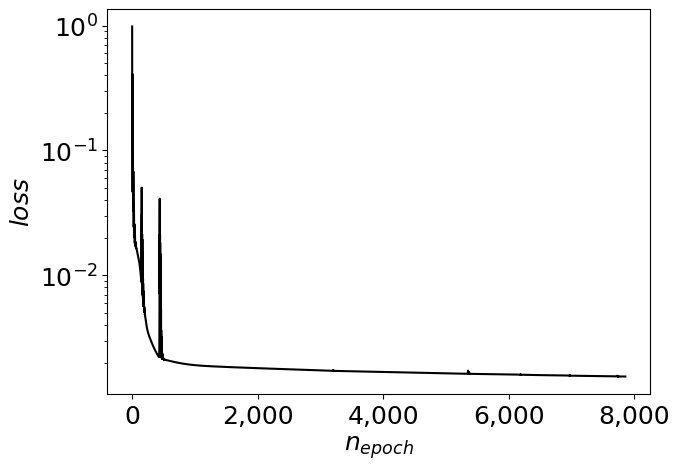

In [16]:
solver.plot_loss_history()

### Plotting the loss modulus plots, frequency sweep (unseen during training)
Here, MFNN is called for all temperatures in `data_test`, which is the Hi-Fi data before the exclusion step. Hollow symbols are entirely masked during the Lo-Fi data generation and MFNN training. The same notation is used for other flow protocols.

/tmp/ipykernel_15313/2778734740.py:17: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  comm = df_train.merge(data_test_fs[sample][1], how='inner')


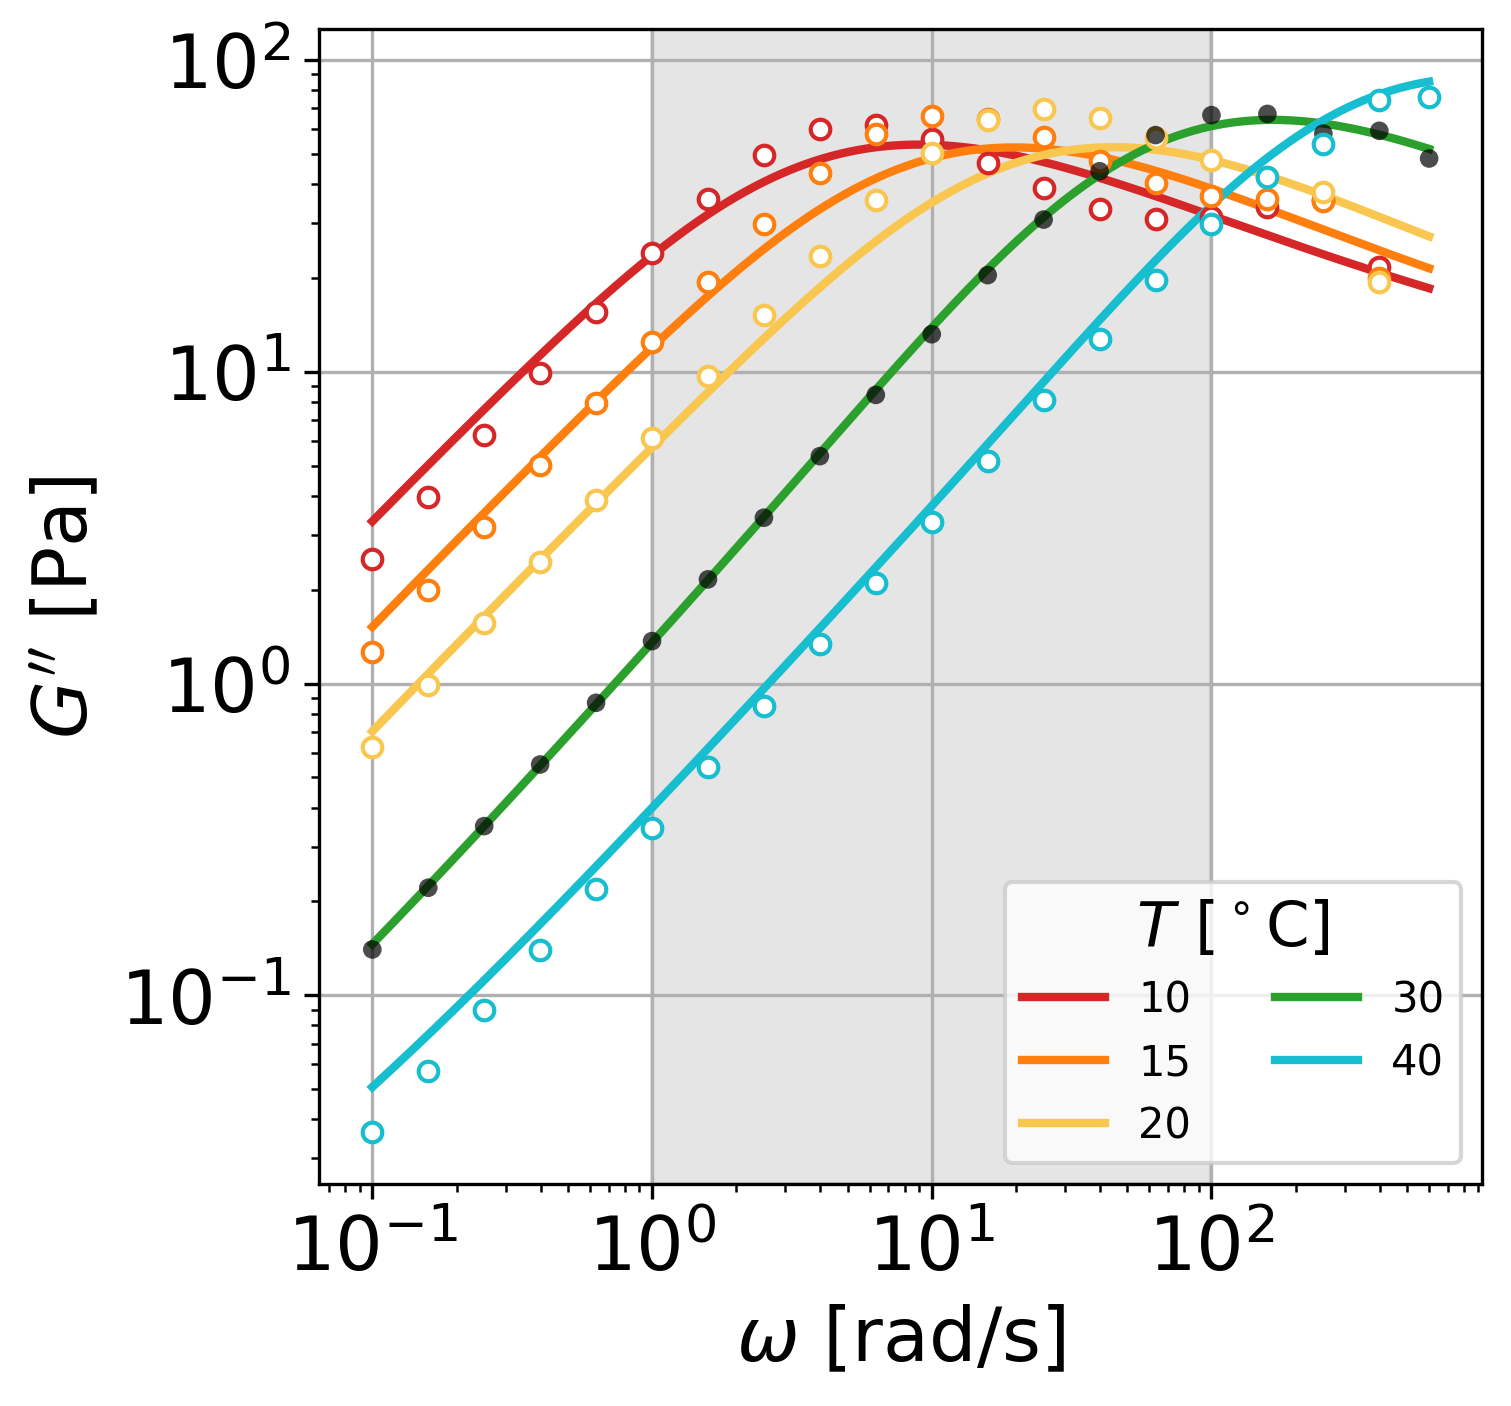

In [17]:
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue']

url_test_fs = 'Oscillatory/Data_HF_FS_test.xlsx'
df_test_fs = pd.read_excel(url_test_fs, sheet_name=None)
data_test_fs = [[k, v] for k, v in df_test_fs.items()]

sample = 0
data_test_fs[sample][1] = data_test_fs[sample][1].dropna()

comm = df_train.merge(data_test_fs[sample][1], how='inner')
comm_T = np.unique(comm['Temperature'])

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub.numpy() - lb.numpy()) + lb.numpy()
    return original_vectors

def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

N_exp = 1000
w_plot = norm(np.linspace(wmin, wmax, N_exp).reshape(-1, 1), wmin, wmax)
T_range = [10., 15., 20., 30., 40.]
St_range = [10., 10., 10., 100., 100.]

St_pred_fs, T_pred_fs, w_pred_fs = [], [], []
Gp_pred_fs = []

for i in range(len(T_range)):
    df_plot = data_test_fs[sample][1][data_test_fs[sample][1].Temperature == T_range[i]]
    x1_test = df_plot['Strain']
    x2_test = df_plot['Temperature']
    x3_test = df_plot['AngFreq']
    y2_test = df_plot['LossM']
    y2_test_std = df_plot['LossMSTD']

    St_plot = norm(torch.log10(torch.tensor(St_range[i], dtype=torch.float32)) * torch.ones(N_exp, 1, dtype=torch.float32), lb[0], ub[0])
    T_plot = norm(torch.tensor(T_range[i], dtype=torch.float32) * torch.ones(N_exp, 1, dtype=torch.float32), lb[1], ub[1])
    X_LF = torch.cat([St_plot, T_plot, torch.tensor(w_plot, dtype=torch.float32)], dim=1)
    y_LF = model_LF(X_LF)
    X_MF = torch.cat((X_LF, y_LF), dim=1)
    y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)

    St_pred_fs = np.append(St_pred_fs, St_plot.numpy())
    T_pred_fs = np.append(T_pred_fs, T_plot.numpy())
    w_pred_fs = np.append(w_pred_fs, w_plot)
    Gp_pred_fs = np.append(Gp_pred_fs, y_MF.detach().numpy())
    if comm_T == T_range[i]:
        condition = (x3_test >= min(comm['AngFreq'])) & (x3_test <= max(comm['AngFreq']))
        ax.scatter(x3_test[condition], y2_test[condition],
                   s=20, color='k', zorder=10, alpha=0.7, edgecolors='none')
        ax.scatter(x3_test[~condition], y2_test[~condition],
                   alpha=1., zorder=10, s=22, marker='o', lw=1., facecolors='white', edgecolors=colors[i])
    else:
        ax.scatter(x3_test, y2_test,
                   alpha=1., zorder=10, s=22, marker='o', lw=1., facecolors='white', edgecolors=colors[i])

    ax.plot(10 ** denorm(w_plot, lb[2], ub[2]), 10**denorm(y_MF.detach().numpy(), lb[3], ub[3]),
             label=int(T_range[i]), lw=2., color=colors[i], alpha=1.)

    legend = ax.legend(ncol=2, loc='lower right', title='$T$ [$\mathrm{^\circ C}$]', fontsize=10)
    plt.setp(legend.get_title(), fontsize=15)

ax.axvspan(1, 100, color='gray', alpha=0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$G\'\'$ $\mathrm{[Pa]}$')
ax.set_xlabel('$\omega$ $\mathrm{[rad/s]}$')
ax.grid()
# plt.savefig("datetime.now().strftime("%Y_%m_%d-%H_%M_%S")+"_FS_Gdp.png", bbox_inches='tight', dpi=600);
plt.show()

### Plotting the loss modulus plots, amplitude sweep
Again, hollow symbols are unseen during the training.

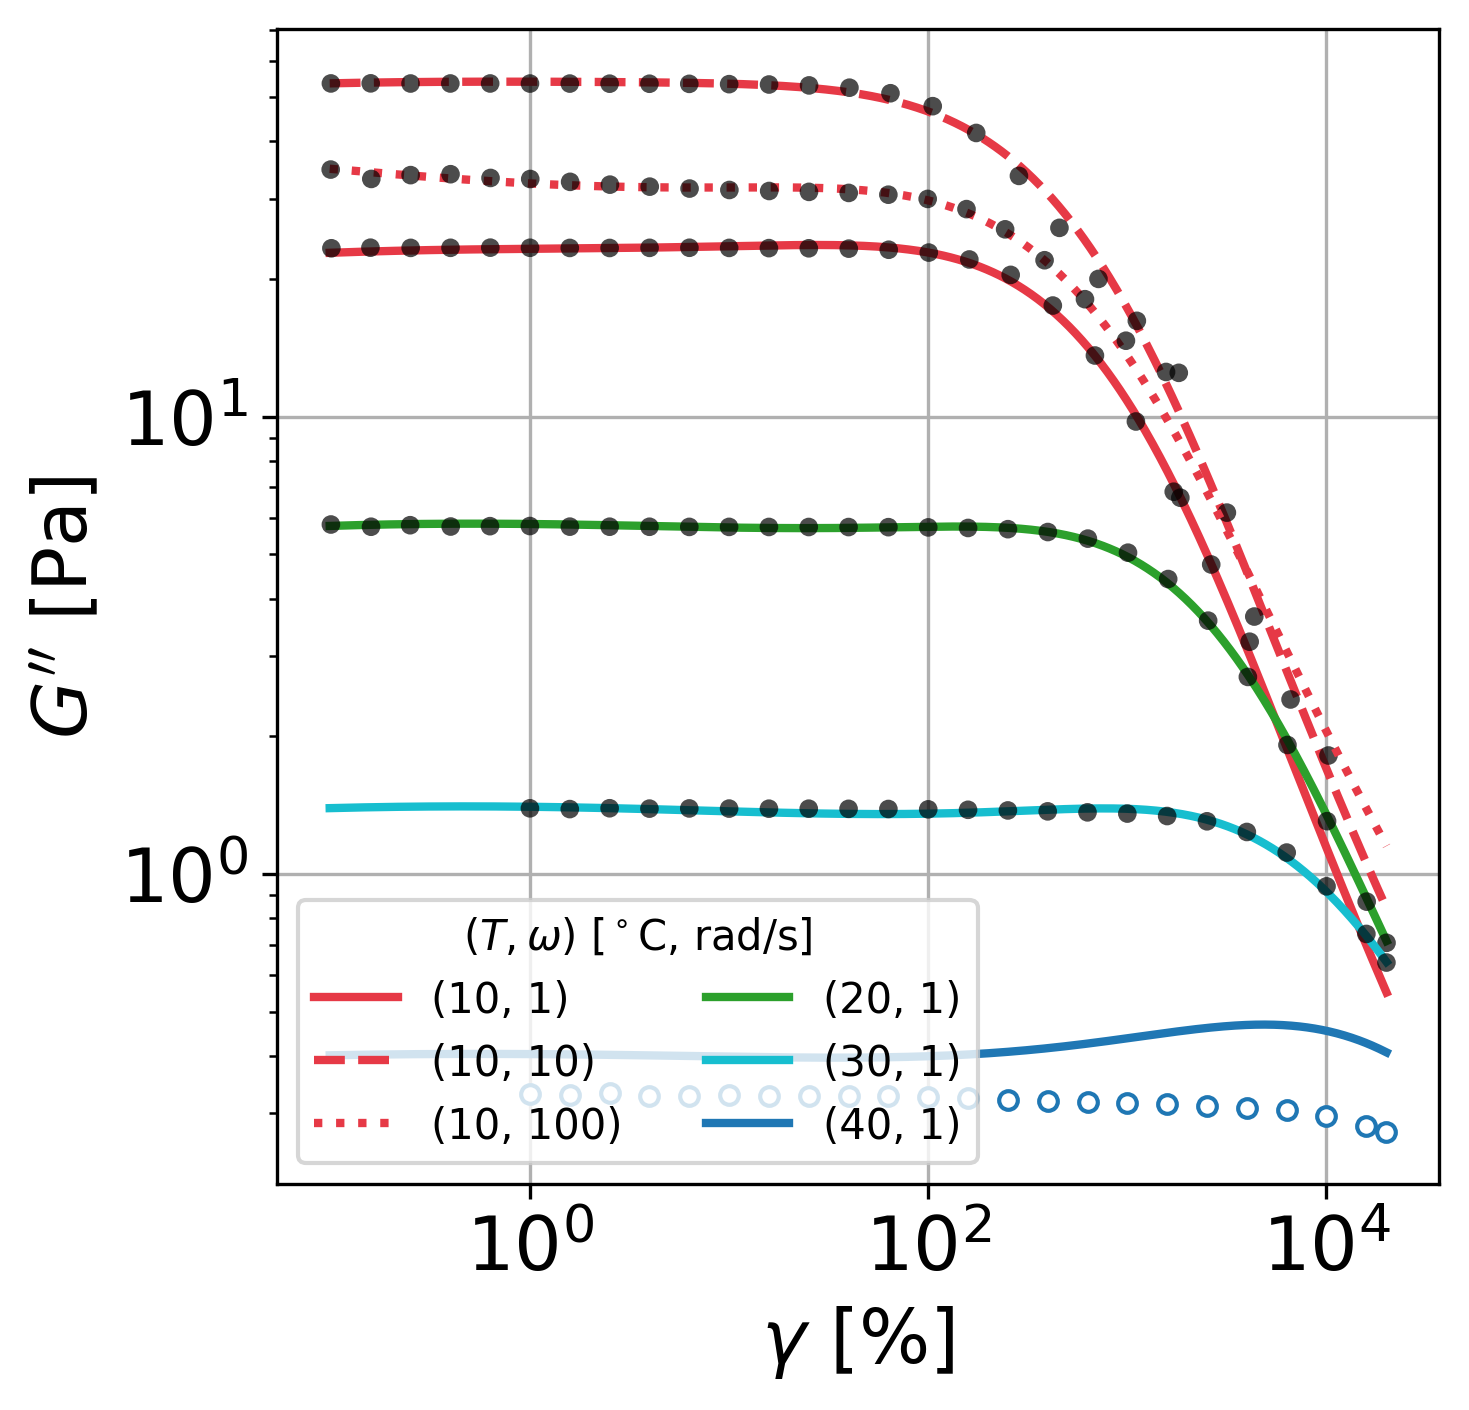

In [18]:
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['#e63946', '#e63946', '#e63946', 'tab:green', 'tab:cyan', 'tab:blue']
ls = ['solid', 'dashed', ':', 'solid', 'solid', 'solid']

url_test_as = 'Oscillatory/Data_HF_AS_plot.xlsx'
df_test_as = pd.read_excel(url_test_as, sheet_name=None)
data_test_as = [[k, v] for k, v in df_test_as.items()]

sample = 0
data_test_as[sample][1] = data_test_as[sample][1].dropna()

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub.numpy() - lb.numpy()) + lb.numpy()
    return original_vectors

def norm(vectors, lb, ub):
    vectors = torch.tensor(vectors, dtype=torch.float32)
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

N_exp = 1000

St_plot = norm(np.linspace(lb[0], ub[0], N_exp).reshape(-1, 1), lb[0], ub[0])
uniques = np.unique(data_test_as[sample][1][['Temperature', 'AngFreq']], axis=0)

St_pred, T_pred, w_pred = [], [], []
Gp_pred = []

for i in range(len(uniques)):
    df_plot = data_test_as[sample][1][data_test_as[sample][1].Temperature == uniques[i][0]]
    df_plot = df_plot[df_plot.AngFreq == uniques[i][1]]
    x1_test = df_plot['Strain']
    x2_test = df_plot['Temperature']
    x3_test = df_plot['AngFreq']
    y2_test = df_plot['LossM']
    y2_test_std = df_plot['LossMSTD']

    T_plot = norm(uniques[i][0] * np.ones(N_exp).reshape(-1, 1), lb[1], ub[1])
    w_plot = norm(np.log10(uniques[i][1]) * np.ones(N_exp).reshape(-1, 1), wmin, wmax)

    X_LF = torch.cat([St_plot, T_plot, w_plot], dim=1)
    y_LF = model_LF(X_LF)
    X_MF = torch.cat((X_LF, y_LF), dim=1)
    y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)

    St_pred = np.append(St_pred, St_plot.numpy())
    T_pred = np.append(T_pred, T_plot.numpy())
    w_pred = np.append(w_pred, w_plot.numpy())
    Gp_pred = np.append(Gp_pred, y_MF.detach().numpy())

    ax.plot(10 ** denorm(St_plot.numpy(), lb[0], ub[0]), 10 ** denorm(y_MF.detach().numpy(), lb[3], ub[3]),
            label='({}, {})'.format(int(uniques[i][0]), int(uniques[i][1])),
            lw=2, color=colors[i], alpha=1., linestyle=ls[i])
    
    if uniques[i][0] in np.unique(denorm(x2_d_HF, lb[1], ub[1])):
        ax.scatter(x1_test, y2_test,
                   s=20, color='k', zorder=2, alpha=0.7, edgecolors='none')
    else:
        ax.scatter(x1_test, y2_test, color=colors[i],
                   alpha=1., zorder=2, s=20, marker='o', lw=1., facecolors='white', edgecolors=colors[i])
    

legend = ax.legend(ncol=2, loc='best',
                    title='$(T, \omega)$ [$\mathrm{^\circ C}$, $\mathrm{rad/s}$]', fontsize=10)
plt.setp(legend.get_title(), fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$G\'\'$ $\mathrm{[Pa]}$')
ax.set_xlabel('$\gamma$ $\mathrm{[\%]}$')
ax.grid()
# plt.savefig("datetime.now().strftime("%Y_%m_%d-%H_%M_%S")+"_AS_Gdp.png", bbox_inches='tight', dpi=600);
plt.show()